<a href="https://colab.research.google.com/github/Rishit605/Helpers/blob/main/Tensorflow_Object_Detection_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using Tensorflow's Object Detection API | If not understandable refer to [this](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#)**

> ## Model Repository downloading

In [ ]:
### Cloning the Tensorflow's Object Detection API ###

! git clone https://github.com/tensorflow/models

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

### Run this command as it is ###

In [ ]:
cd ..

> ## Dataset Preparation

In [ ]:
### Donwload the dataset in this cell ###
### REMEBER TO KEEP THE DATASET IN TFRecord FORMAT ###


In [17]:
### TO CONVERT TO TFRECORDS FORMAT ###

import tensorflow as tf
import os
from PIL import Image

def create_tf_example(image_path, annotation_path):
    # Read the image file
    with tf.io.gfile.GFile(image_path, 'rb') as f:
        image_data = f.read()

    # Read the annotation file
    with open(annotation_path, 'r') as f:
        annotation_data = f.read().strip().split()

    # Extract the necessary information from the annotation data
    label = int(annotation_data[0])
    xmin = float(annotation_data[1])
    ymin = float(annotation_data[2])
    xmax = float(annotation_data[3])
    ymax = float(annotation_data[4])

    # Create the TFRecord example
    example = tf.train.Example(features=tf.train.Features(feature={
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=[xmin])),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=[ymin])),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=[xmax])),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=[ymax])),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }))

    return example

def convert_to_tfrecords(image_dir, annotation_dir, output_dir, train_ratio=0.8):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the list of image files
    image_files = os.listdir(image_dir)

    # Calculate the split point for training and validation sets
    split_point = int(train_ratio * len(image_files))

    # Create TFRecord writers for training and validation sets
    train_writer = tf.io.TFRecordWriter(os.path.join(output_dir, 'train.tfrecord'))
    val_writer = tf.io.TFRecordWriter(os.path.join(output_dir, 'val.tfrecord'))

    # Iterate over the images and annotations
    for i, image_file in enumerate(image_files):
        # Get the corresponding annotation file
        annotation_file = image_file.replace('.jpg', '.txt')
        image_path = os.path.join(image_dir, image_file)
        annotation_path = os.path.join(annotation_dir, annotation_file)

        # Create the TFRecord example
        example = create_tf_example(image_path, annotation_path)

        # Write the example to the appropriate TFRecords file
        if i < split_point:
            train_writer.write(example.SerializeToString())
        else:
            val_writer.write(example.SerializeToString())

    # Close the TFRecord writers
    train_writer.close()
    val_writer.close()

# Example usage
image_dir = '/content/dataset/images'
annotation_dir = '/content/dataset/labels'
output_dir = '/content/tfconvdat'

convert_to_tfrecords(image_dir, annotation_dir, output_dir, train_ratio=0.8)

## [Tensorflow Model Garden](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) Download the models from this link.

### You can download any model, just be careful for the image size as large images model size would take more RAM and GPU.

In [ ]:
### This is the RetinaNet model ###
### Running this will donwload the model as a tar file, which contains the model's checkpoint and pipeline config file. ###

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz

In [12]:
### Extracting the tar file ###

!tar -xf /content/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz

In [13]:
### Moving the tar file to the API directory itself - "/content/models/research/object_detection/test_data/" ###

!mv /content/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8 -t /content/models/research/object_detection/test_data/

## Then you need to go to the model folder that we have just moved, you will see 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz' folder, opening it you will see the pipline.config file and checkpoints folder.

>

In [ ]:
pipeline_config = '/content/models/research/object_detection/test_data/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config'
checkpoint_path = '/content/models/research/object_detection/test_data/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/pipeline.config' ## If using different models, path will reamin the same except the name of the folder 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'.
### NOTE: checkpoint file wil be named "ckpt-0" and not "ckpt-0.index".

In the pipeline.config file, change the pointed parameters and path.

#  **Change the Batch Size to 4, Google colab cannot handle larger than 4 batch_size.**
```

ssd {
    num_classes: 90 <-Change this to the desire num_classes.
    image_resizer {
      fixed_shape_resizer {
        height: 640 <- Change these to your image size.
        width: 640
      }

# **In different models, their pipeline.config, edit the 'num_steps', 1000 steps = 1 epoch**
sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.03999999910593033
          total_steps: 25000
          warmup_learning_rate: 0.013333000242710114
          warmup_steps: 2000
        }

fine_tune_checkpoint: "PATH_TO_BE_CONFIGURED"  <- Change This path to be your checkpoint path. ### NOTE: checkpoint file wil be named "ckpt-0" and not "ckpt-0.index".
  num_steps: 25000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "classification" <- Change this to 'detection'
  use_bfloat16: true <- Change this to 'false',
  fine_tune_checkpoint_version: V2
}

train_input_reader {
  label_map_path: "PATH_TO_BE_CONFIGURED" <- Change This path to be your train labelmap file.
  tf_record_input_reader {
    input_path: "PATH_TO_BE_CONFIGURED" <- Change this to your train tfrecords file
  }


eval_input_reader {
  label_map_path: "PATH_TO_BE_CONFIGURED" <- Change This path to be your train/test/validation labelmap file.
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "PATH_TO_BE_CONFIGURED" <- Change this to your test/validation tfrecords file.
  }
```



In [ ]:
### Training Funtion Calling ###

! python /content/models/research/object_detection/model_main_tf2.py --model_dir=/content/model_output --pipeline_config_path=/content/models/research/object_detection/test_data/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/pipeline.config

In [ ]:
### Evalution Funtion Calling ###

! python /content/models/research/object_detection/model_main_tf2.py --model_dir=/content/model_output --pipeline_config_path=/content/models/research/object_detection/test_data/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/pipeline.config --checkpoint_dir=/content/model_output

In [ ]:
### Model Exporter Function ###

!python /content/models/research/object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path /content/models/research/object_detection/test_data/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/pipeline.config --trained_checkpoint_dir /content/model_output --output_directory /content/model_exported

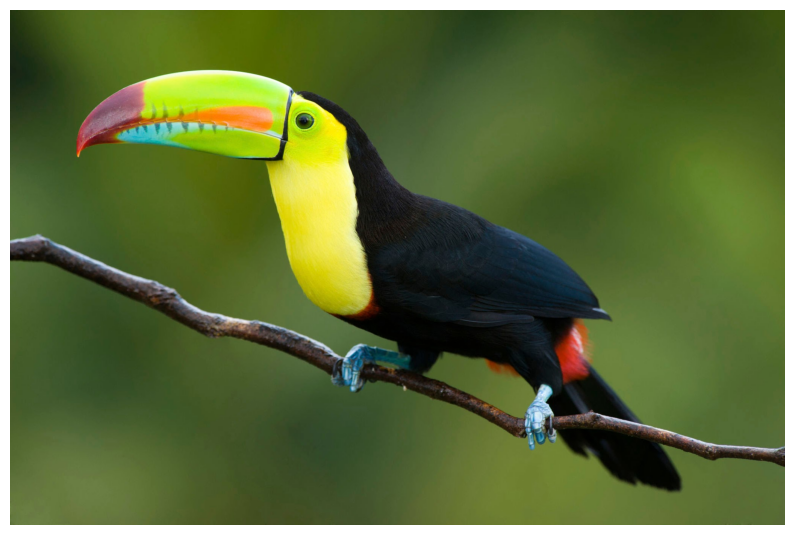

In [ ]:
### ERROR IS NO PREDICTION IS VISIBLE ###
### Visualizing The Prediction ###

import tensorflow as tf
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Path to the exported model directory
model_dir = '/content/model_exported/saved_model'

# Load the saved model
model = tf.saved_model.load(model_dir)

# Preprocess the input data
def preprocess_image(image):
    # Resize the image to the model's input size
    image = cv2.resize(image, (640,640))
    # Normalize the image pixel values
    image = image / 255.0
    # Convert the image to a tensor and add a batch dimension
    image = np.expand_dims(image, axis=0)
    return image

# Load and preprocess the input image
image_path = '/content/licensed-image.jpg'
image = cv2.imread(image_path)
preprocessed_image = preprocess_image(image)

# Run inference on the input image
outputs = model(preprocessed_image)

# Extract the necessary information from the model's output
boxes = outputs['detection_boxes'][0].numpy()
scores = outputs['detection_scores'][0].numpy()
classes = outputs['detection_classes'][0].numpy().astype(np.int32)

# Process the output
threshold = 0.25  # Confidence threshold for detected objects
filtered_boxes = boxes[scores >= threshold]
filtered_classes = classes[scores >= threshold]

# Visualize the results
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
for box, cls in zip(filtered_boxes, filtered_classes):
    ymin, xmin, ymax, xmax = box
    xmin = int(xmin * image.shape[1])
    xmax = int(xmax * image.shape[1])
    ymin = int(ymin * image.shape[0])
    ymax = int(ymax * image.shape[0])
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.text(xmin, ymin - 10, f'Class: {cls}', color='green', fontsize=12, fontweight='bold')
plt.show()
# boxes

In [ ]:
!tensorboard --logdir=/content/model_output

2023-07-02 07:45:00.842167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C
